# This notebook: 
## 1. extracts satellite chlorophyll-a (chl-a) data from ERDDAP using specified coordinates and time windows
## 2. maps chl-a for a selected time
## 3. identifies the month at which the lowest and highest chl value are reached over a yearly cycle at the pixel level
## 4. maps the month value per pixel for the lowest and highest chl level

### Download data

In [3]:
import xarray as xr
import numpy as np
import requests
import os

# 1. Define Coordinates and Time
n_lat, s_lat = 31, 21
e_lon, w_lon = -79.5, -90
start_time = '2003-01-16T00:00:00Z'
end_time = '2025-10-16T00:00:00Z'

# 2. Construct the ERDDAP URL (https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdMH1chlamday_R2022SQ.graph)
# We use f-strings for cleaner string formatting compared to strcat
base_url = "https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdMH1chlamday_R2022SQ.nc"
query = f"?chlor_a[({start_time}):1:({end_time})][({n_lat}):1:({s_lat})][({w_lon}):1:({e_lon})]"
full_url = base_url + query

filename = 'chla_data.nc'

# 3. Download the data
print(f"Downloading data from: {full_url}")
response = requests.get(full_url, timeout=1200)

if response.status_code == 200:
    with open(filename, 'wb') as f:
        f.write(response.content)
    print("Download complete.")
else:
    print(f"Failed to download data. Status code: {response.status_code}")

# 4. Load and Process Data
# xarray automatically handles the dimensions and meshgrid logic
ds = xr.open_dataset(filename)

# Extract variables as numpy arrays (similar to ncread)
lat = ds.latitude.values
lon = ds.longitude.values
chla = ds.chlor_a.values
time = ds.time.values

# Python equivalent of [lat1, lon1] = meshgrid(lat, lon)
lon1, lat1 = np.meshgrid(lon, lat)

# View the dataset structure
print(ds)

Download complete.
<xarray.Dataset> Size: 66MB
Dimensions:    (time: 271, latitude: 241, longitude: 253)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2003-01-16 2003-02-16 ... 2025-10-16
  * latitude   (latitude) float32 964B 31.02 30.98 30.94 ... 21.1 21.06 21.02
  * longitude  (longitude) float32 1kB -90.02 -89.98 -89.94 ... -79.56 -79.52
Data variables:
    chlor_a    (time, latitude, longitude) float32 66MB nan nan ... 0.1075
Attributes: (12/52)
    _lastModified:                     2025-12-10T00:25:19.000Z
    cdm_data_type:                     Grid
    Conventions:                       CF-1.6 ACDD-1.3, COARDS
    creator_email:                     data@oceancolor.gsfc.nasa.gov
    creator_name:                      NASA/GSFC/OBPG
    creator_type:                      group
    ...                                ...
    summary:                           Moderate Resolution Imaging Spectrorad...
    temporal_range:                    month
    time_coverage_end:       

### Map chl-a for a selected month and year

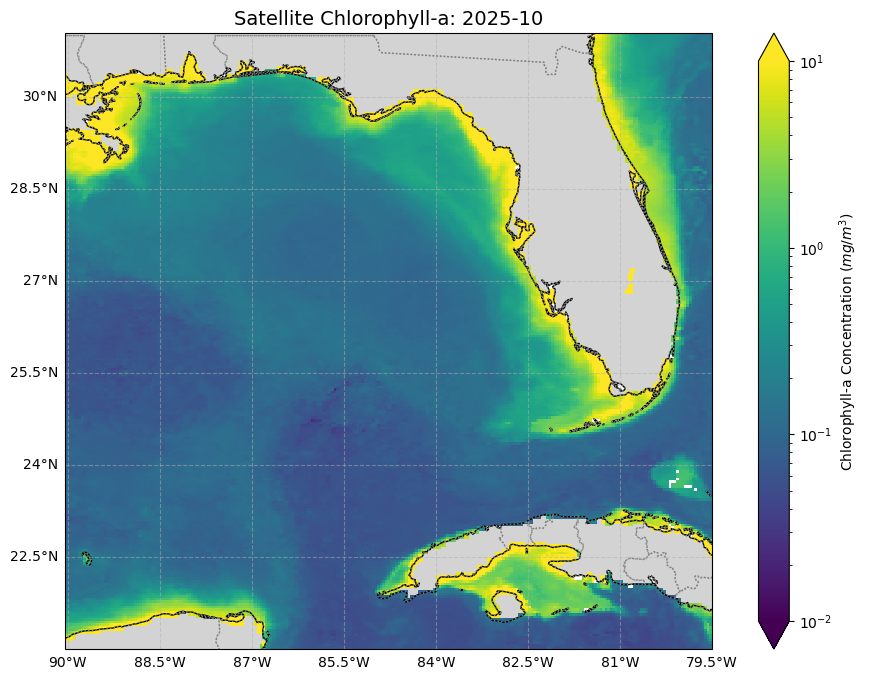

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm

# 1. Select the specific time slice
# Example: Select January 2015. 
# You can use a string 'YYYY-MM' with xarray's .sel() method
target_time = '2025-10'
data_slice = ds.chlor_a.sel(time=target_time, method='nearest')

# 2. Setup the map projection
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# 3. Plot the data
# We use LogNorm because Chl-a values are typically log-distributed
im = ax.pcolormesh(ds.longitude, ds.latitude, data_slice,
                   transform=ccrs.PlateCarree(),
                   cmap='viridis', 
                   norm=LogNorm(vmin=0.01, vmax=10))

# 4. Add geographic features
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# 5. Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# 6. Add Colorbar and Labels
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, extend='both')
cbar.set_label('Chlorophyll-a Concentration ($mg/m^3$)')

plt.title(f'Satellite Chlorophyll-a: {target_time}', fontsize=14)
plt.show()

### To find the month when the seasonal peak occurs for every pixel, we need to perform these steps:
###  1. Group the data by month.
###  2. Calculate the climatological mean (the "average" year) to smooth out episodic events (like hurricanes or odd blooms).
###  3. Find the index (month) where the maximum value occurs for every latitude/longitude point.

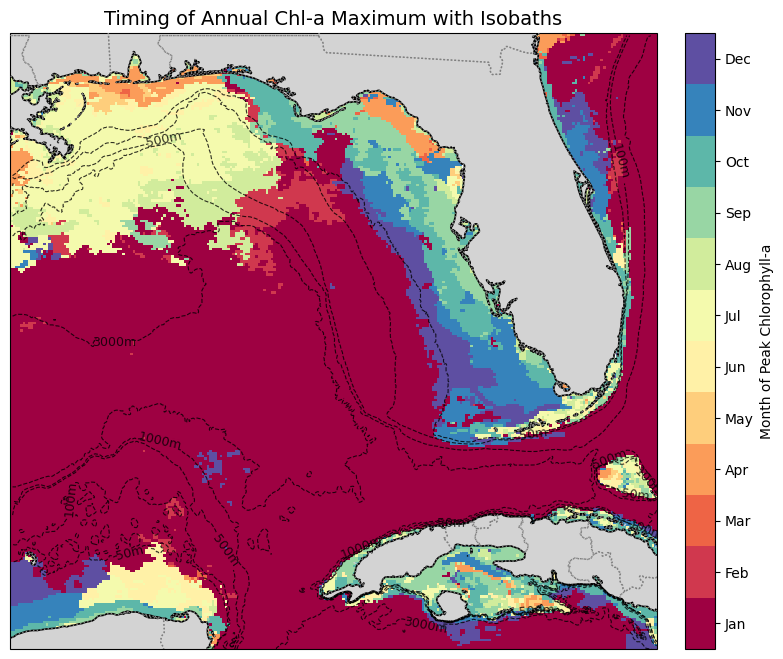

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import requests
import os

# --- 1. Calculate the Chl-a Peak Month ---
climatology = ds.chlor_a.groupby('time.month').mean(dim='time')
peak_month = climatology.idxmax(dim='month').load()

# --- 2. Download Bathymetry Data (ETOPO) ---
topo_filename = 'topo_data.nc'

# ERDDAP Dataset ID for ETOPO 2022 (higher resolution and more reliable)
# We use .nc (NetCDF) format
topo_url = (
    f"https://coastwatch.pfeg.noaa.gov/erddap/griddap/etopo180.nc?altitude"
    f"[({min(s_lat, n_lat)}):1:({max(s_lat, n_lat)})]"
    f"[({min(w_lon, e_lon)}):1:({max(w_lon, e_lon)})]"
)

if not os.path.exists(topo_filename):
    print(f"Attempting to download bathymetry from: {topo_url}")
    try:
        r = requests.get(topo_url, timeout=120)
        if r.status_code == 200:
            with open(topo_filename, 'wb') as f:
                f.write(r.content)
            print("Bathymetry download complete.")
        else:
            print(f"Download failed with status {r.status_code}. Using fallback method...")
            # Fallback: Natural Earth (less precise but won't crash)
            topo_ds = None 
    except Exception as e:
        print(f"Error occurred: {e}")
        topo_ds = None

# --- 3. Load Data and Setup Plot ---
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
cmap = plt.get_cmap('Spectral', 12)

# --- 4. Plot Chl-a Peak Month ---
im = ax.pcolormesh(ds.longitude, ds.latitude, peak_month,
                   transform=ccrs.PlateCarree(),
                   cmap=cmap, vmin=0.5, vmax=12.5, zorder=1)

# --- 5. Add Bathymetry Contours (If download succeeded) ---
if os.path.exists(topo_filename):
    topo_ds = xr.open_dataset(topo_filename)
    # ETOPO uses 'latitude'/'longitude' names
    # Ensure levels match ocean depths (negative)
    levels = [-5000, -3000, -1000, -500, -100, -50]
    
    contours = ax.contour(topo_ds.longitude, topo_ds.latitude, topo_ds.altitude, 
                           levels=levels, colors='black', 
                           linewidths=0.8, alpha=0.8, 
                           transform=ccrs.PlateCarree(), zorder=4)

    plt.clabel(contours, inline=True, fontsize=9, fmt={lev: f'{int(abs(lev))}m' for lev in levels})

# --- 6. Add Geographic Features ---
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)
ax.add_feature(cfeature.COASTLINE, linewidth=1.2, zorder=3)
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray', zorder=3)

# --- 7. Formatting ---
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.03, ticks=range(1, 13))
cbar.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
cbar.set_label('Month of Peak Chlorophyll-a')

plt.title('Timing of Annual Chl-a Maximum with Isobaths', fontsize=14)
plt.show()

### Seasonal Chl-a Curves by Peak-Month Group

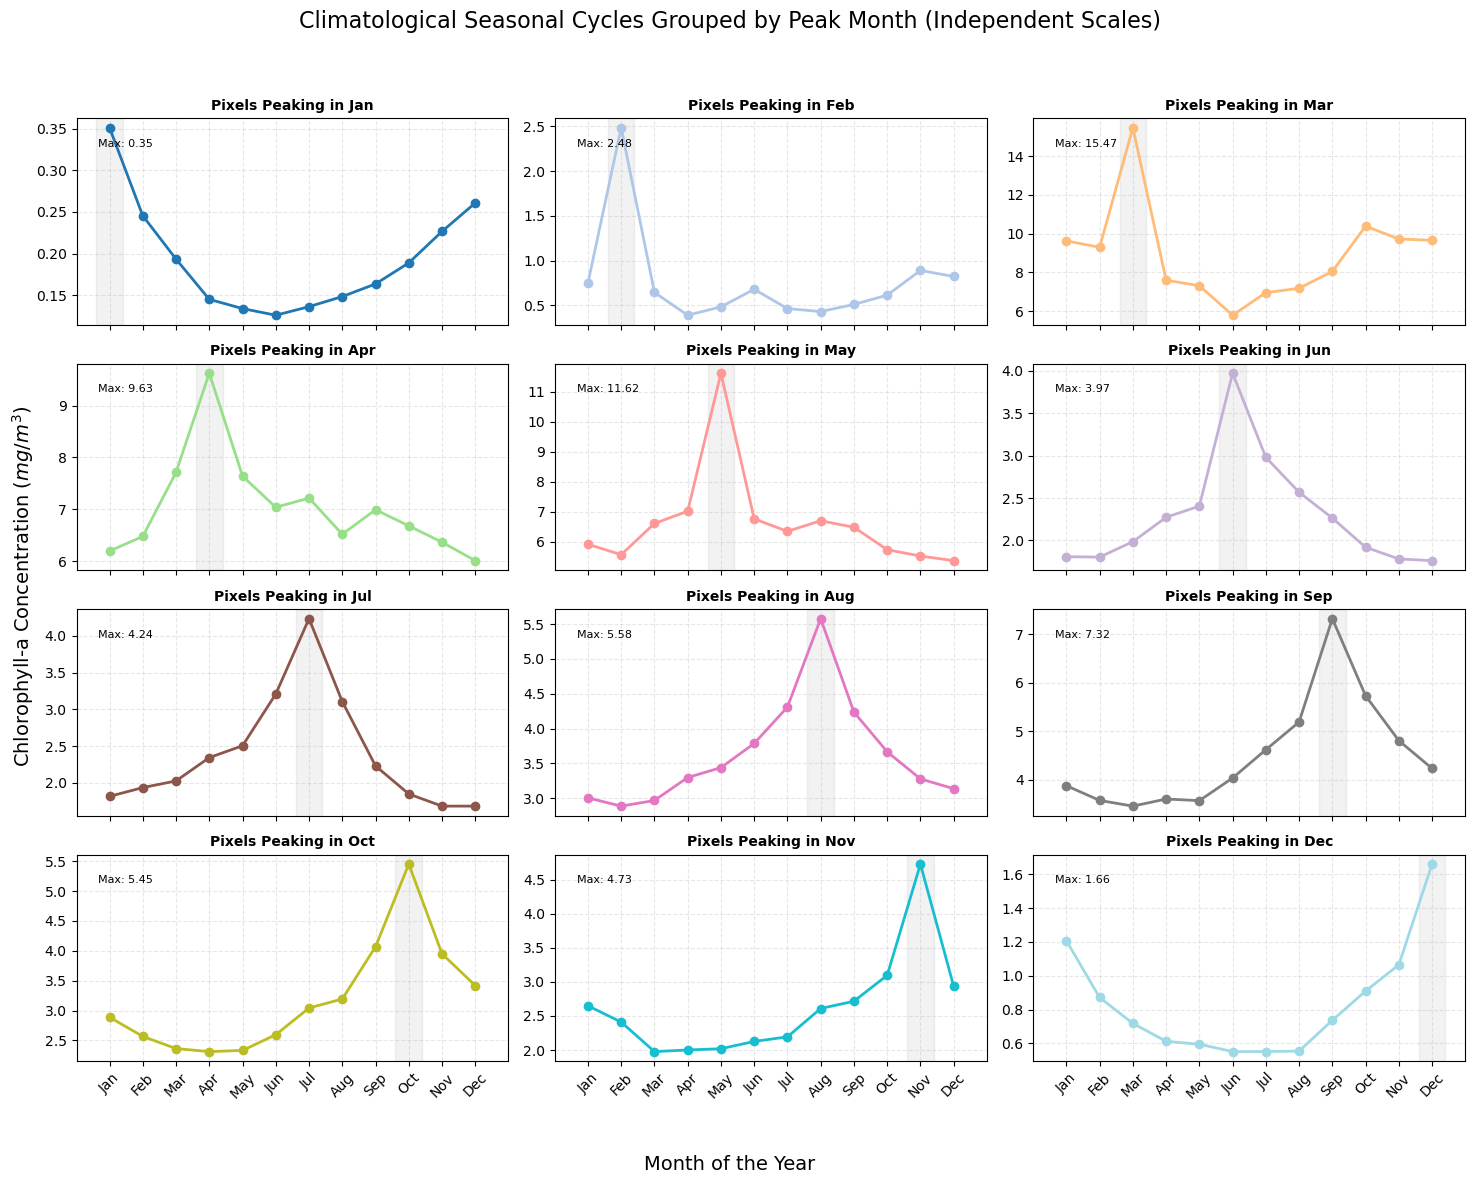

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Calculate the Monthly Climatology
climatology = ds.chlor_a.groupby('time.month').mean(dim='time').load()

# 2. Setup the figure for 12 subplots
# Changed sharey to False so each plot scales to its own max/min
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=True, sharey=False)
axes = axes.flatten()
months_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x_axis = np.arange(1, 13)

# 3. Use 'tab20' to stay consistent with the discrete map colors
cmap = plt.get_cmap('tab20', 12)

for i in range(12):
    month_id = i + 1
    ax = axes[i]
    
    # Mask pixels that peak in this specific month
    mask = (peak_month == month_id)
    
    # Check if there are any pixels in this group to avoid Mean-of-Empty-Slice warnings
    if mask.any():
        group_curve = climatology.where(mask).mean(dim=['latitude', 'longitude'])
        
        # Plot the curve
        ax.plot(x_axis, group_curve, marker='o', color=cmap(i), linewidth=2)
        
        # Set titles and formatting
        ax.set_title(f'Pixels Peaking in {months_labels[i]}', fontsize=10, fontweight='bold')
        ax.grid(alpha=0.3, linestyle='--')
        
        # Highlight the peak month
        ax.axvspan(month_id - 0.4, month_id + 0.4, color='gray', alpha=0.1)
        
        # Add the specific max/min values to the plot as text for context
        ax.text(0.05, 0.9, f"Max: {group_curve.max().values:.2f}", 
                transform=ax.transAxes, fontsize=8, verticalalignment='top')
    else:
        ax.text(0.5, 0.5, 'No pixels in this group', ha='center', va='center')
        ax.set_title(f'Pixels Peaking in {months_labels[i]}', fontsize=10)

# 4. Global formatting
# Set ticks for the bottom row
for ax in axes[-3:]:
    ax.set_xticks(x_axis)
    ax.set_xticklabels(months_labels, rotation=45)

fig.supxlabel('Month of the Year', fontsize=14)
fig.supylabel('Chlorophyll-a Concentration ($mg/m^3$)', fontsize=14)
fig.suptitle('Climatological Seasonal Cycles Grouped by Peak Month (Independent Scales)', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()